We're going to develop a classifier that predicts the next day based on a sequence of protests. We'll then move on to a sequence-by-sequence model.

In [2]:
import pandas as pd
import numpy as np
import torch, csv, os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
#from datetime import date, datetime
import datetime


First, let's import the data we'll use. To use the forward-looking indicators, we'll shift a number of periods into the future, determined by the "periods2shift" parameter.

In [ ]:
workDir = r'.\Data'
outDir = r'.\Results

periods2shift = -2

protestDF = pd.read_csv(r'{}\Data\Protest\protestas_original.csv'.format(workDir), parse_dates = ['date'], index_col = 'date')#, delimiter = ';')
protestDF = protestDF[~protestDF.personas_sin.isna()]
# Trabajar con el archivo actualizado
protestDF = protestDF.drop(columns = ['num_eventos', 'personas']
              ).rename(columns = {'num_eventos_sin': 'num_eventos', 'personas_sin': 'personas'})

rsuiDF = pd.read_csv(r'{}\Data\GDELT\RSU_index.csv'.format(workDir), parse_dates = ['date'], index_col = 'date'
                                                                    ).shift(periods = periods2shift).drop(columns = ['Unnamed: 0'])
wtiDF = pd.read_csv(r'{}\Data\Gasoline_Pump_Prices\WTI_final_act.csv'.format(workDir), parse_dates = ['date'], 
                    index_col = 'date').shift(periods = periods2shift).drop(columns = ['Unnamed: 0'])

acledDF = pd.read_csv(r'{}\Data\ACLED\acled_final_new.csv'.format(workDir), parse_dates = ['date'], index_col = 'date'
                                                                     )#.drop(columns = ['Unnamed: 0']).shift(periods = periods2shift)

# Append RSUI indexes
protestDF = pd.merge(protestDF, rsuiDF[['RSUI_A_w', 'RSUI_B_m']], how='left', left_index=True, right_index=True).drop(columns = ['Unnamed: 0'])
# Append wti prices
protestDF = pd.merge(protestDF, wtiDF, how='left', left_index=True, right_index=True)
# Append gasoline prices
protestDF = pd.merge(protestDF, acledDF[['n_ecuador', 'acled_d', 'acled_w', 'acled_m']], how='left', left_index=True, right_index=True)

protestDF = protestDF.astype({c: 'float' for c in protestDF.columns})

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

scalers = {}
for x in protestDF.columns:
    scalers[x] = StandardScaler().fit(protestDF[x].values.reshape(-1, 1))
    
norm_df = protestDF.copy()
for i, key in enumerate(scalers.keys()):
    norm = scalers[key].transform(norm_df[key].values.reshape(-1, 1))
    norm_df.loc[:, key] = norm    

C:\Users\Ramon\AppData\Local\Temp\ipykernel_13660\3224431698.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[-0.34209851]
 [-0.34209851]
 [-0.34209851]
 ...
 [-0.29227091]
 [ 0.70428108]
 [-0.29227091]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  norm_df.loc[:, key] = norm


## Graph Shifted series

<Axes: xlabel='date'>

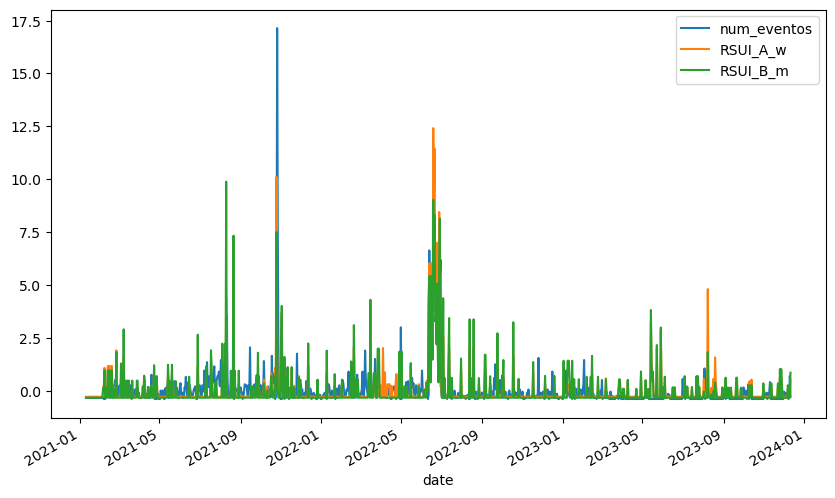

In [8]:
norm_df[['num_eventos', 'RSUI_A_w', 'RSUI_B_m']].plot(figsize = (10, 6))

<Axes: xlabel='date'>

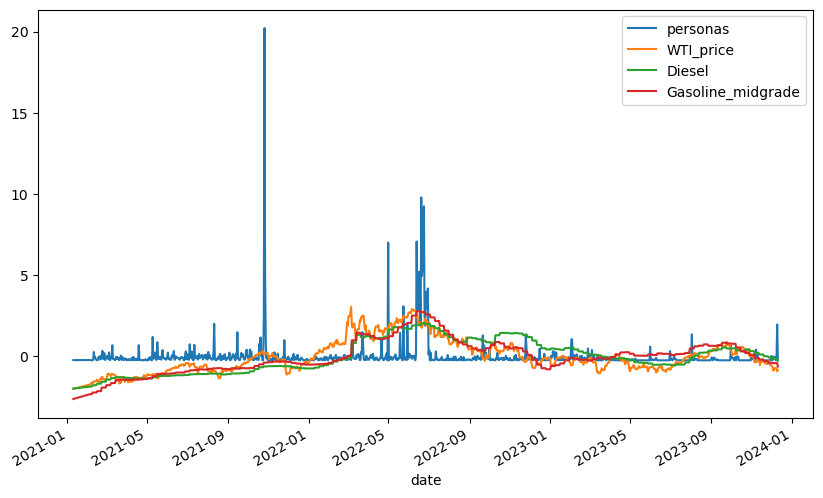

In [9]:
norm_df[['personas', 'WTI_price']].plot(figsize = (10, 6))

<Axes: xlabel='date'>

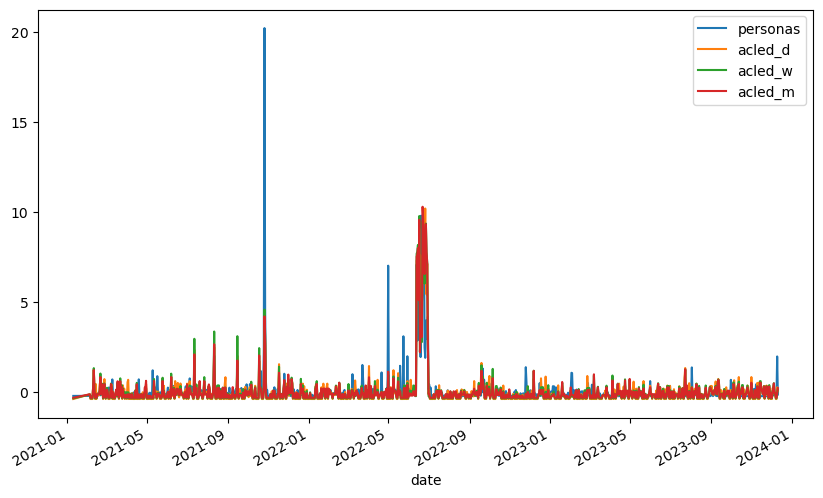

In [11]:
norm_df[['personas', 'acled_d', 'acled_w', 'acled_m']].plot(figsize = (10, 6))

<Axes: xlabel='date'>

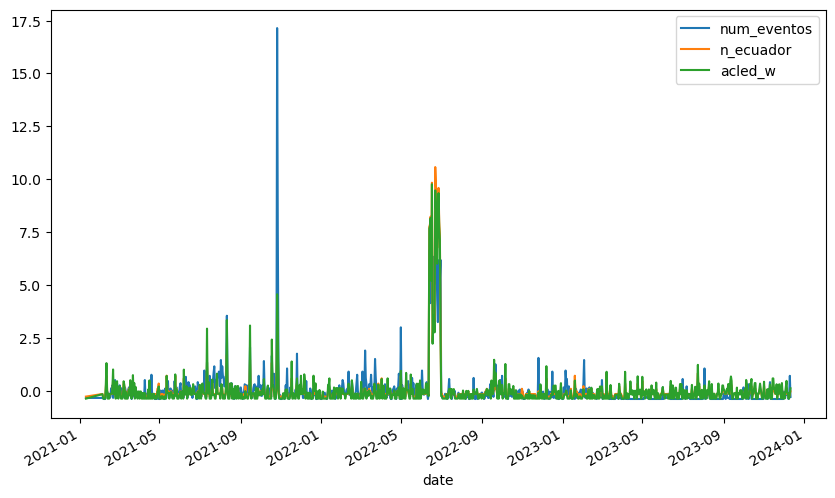

In [12]:
norm_df[['num_eventos', 'n_ecuador', 'acled_w']].plot(figsize = (10, 6))

## Construct Validation Dataset

To construct the validation datasets, we are going to make sure that the different peaks in protests are adequately represented. For this reason, we are going to identify local maxima in a 2 week period.

In [9]:
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

SEED = 1009
test_size = 0.2
window = 7 # number of points to be checked before and after
protestas_2022 = '2022-06-20'
second_protest = '2022-05-01'

# Find local peaks
norm_df['local_max_per'] = norm_df.iloc[argrelextrema(norm_df.personas.values, np.greater_equal, order=window)[0]]['personas']

# Get 20% sample of peaks
sampled_peaks = norm_df[~norm_df.local_max_per.isna()].sample(frac = test_size, random_state = SEED)
if pd.to_datetime(protestas_2022) in sampled_peaks.index:
    sampled_peaks = sampled_peaks.drop(protestas_2022, axis ='index')
if pd.to_datetime(second_protest) in sampled_peaks.index:
    sampled_peaks = sampled_peaks.drop(second_protest, axis ='index')

## Create Validation Set based in sampled peaks
norm_df['is_validation'] = False
 # Add Half of 2022 protests
norm_df.loc['2022-06-23':'2022-07-02', 'is_validation'] = True

# Add 2023-03-08 protest 
norm_df.loc['2023-03-03':'2023-03-13', 'is_validation'] = True

# Add 2023-03-08 protest 
norm_df.loc['2021-09-12':'2021-09-22', 'is_validation'] = True

 # Add Sampled Peaks
for i, row in sampled_peaks.iterrows():
    start, end = i - datetime.timedelta(days = 5), i + datetime.timedelta(days = 5)
    norm_df.loc[f'{start.year}-{start.month}-{start.day}':f'{end.year}-{end.month}-{end.day}', 'is_validation'] = True

 

<Axes: xlabel='date'>

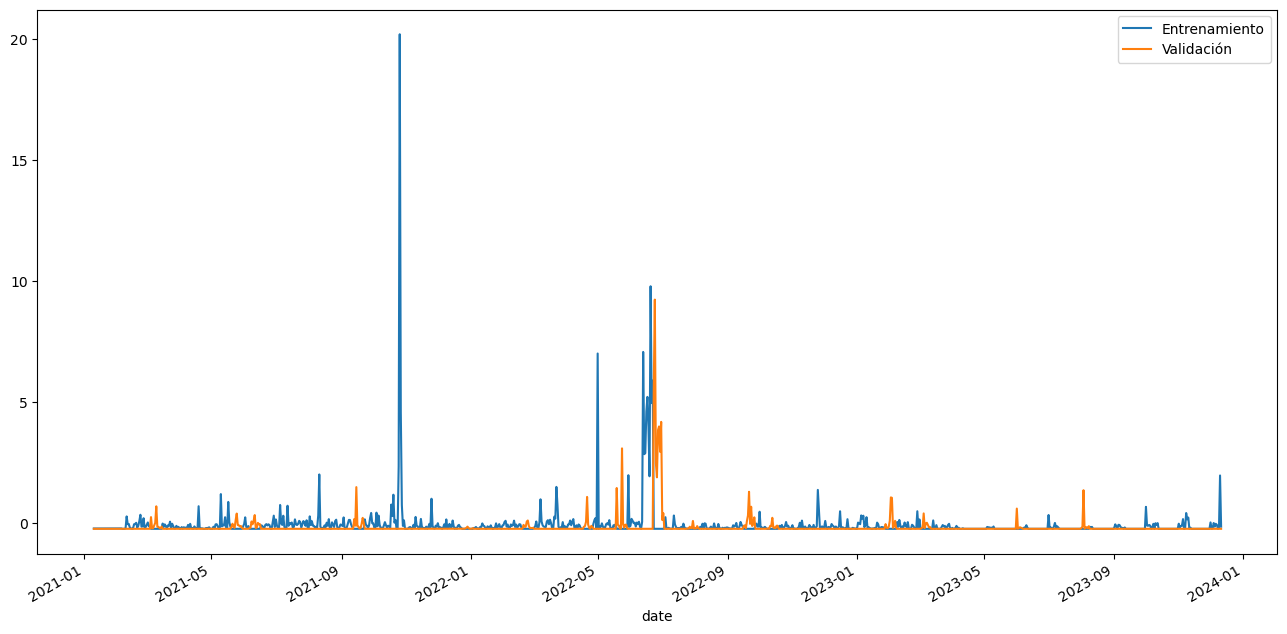

In [10]:
fig, ax = plt.subplots(figsize = (10, 6))   
to_graph = norm_df[['personas', 'is_validation']].copy()
to_graph['validation'] = to_graph.personas.min()
to_graph.loc[to_graph.is_validation, 'validation'] = to_graph.personas
to_graph['train'] = to_graph.personas.min()
to_graph.loc[~to_graph.is_validation, 'train'] = to_graph.personas

to_graph[['train', 'validation']].rename(columns = {'train': 'Entrenamiento', 'validation': 'Validación'}).plot(ax = ax, figsize = (16, 8))



First Optimization Procedure

In [29]:
from sklearn.model_selection import ParameterSampler
import math
import lstm_classes
import support_functions

param_grid = {
    'batch_size': [16, 32],
    'n_hidden': [16, 32, 50, 64],
    'bidirectional': [True, False], #True
    'n_lstm_layers': [1, 2, 3],
    'n_dnn_layers': [2, 3],
    'seed': [1001, 1911]    
}

n_iter =  math.prod([len(p_l) for p, p_l in param_grid.items()])
param_list = list(ParameterSampler(param_grid, n_iter =n_iter))


In [31]:

X_COLUMNS = ['RSUI_A_w', 'RSUI_B_m', 'n_ecuador', 'acled_w', 'WTI_price']

nout= 2 # Periods to predict
sequence_len= 12
ninp= len(X_COLUMNS)

# Training
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
clip_max_norm = None
initial_lr = 1e-4
EPOCHS = 90
TOLERANCE = 40

results_dict = []
for i, params in enumerate(param_list):
    print(f'Iter {i}:', params)
    
    # Instantiate the model
    model = LSTMForecaster(ninp, n_outputs = nout, sequence_len = sequence_len, n_hidden = params['n_hidden'], n_deep_layers = params['n_dnn_layers'], use_cuda = USE_CUDA, 
                           bidirectional = params['bidirectional'], n_lstm_layers = params['n_lstm_layers']).to(device)
    
    criterion = nn.MSELoss().to(device)
    #optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = None
    
    dataset = SequenceMaster(norm_df, tw = sequence_len, pw = nout, y_column = 'personas', x_columns = X_COLUMNS, validation_column = 'is_validation')
    
    trainloader = DataLoader(dataset.train, batch_size = params['batch_size'], shuffle = True, drop_last = True)
    testloader = DataLoader(dataset.validation, batch_size = params['batch_size'], shuffle = True, drop_last = True)
    total_steps = len(trainloader) // EPOCHS    
    
    x_past, y_past, x_future, y_target  = next(iter(testloader))
    x_past.shape, y_past.shape, x_future.shape, y_target.shape

    ## #Training Loop
    best_loss, steps_without_improvement = float('inf'), 0
    # Set seed
    torch.manual_seed(params['seed'])
    for epoch in range(EPOCHS):
        train_loss, valid_loss = 0.0, 0.0
    
        # train step
        model.train()
        for x_past, y_past, x_future, y_target in trainloader:
            optimizer.zero_grad()
            x_past = x_past.to(device)
            y_target  = y_target.squeeze().to(device)
            # Forward Pass
            preds = model(x_past).squeeze()
    
            loss = criterion(preds, y_target)
            train_loss += loss.item()
            loss.backward()
            if clip_max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = clip_max_norm)              
            optimizer.step()
            if scheduler is not None:    scheduler.step()   
            
        epoch_loss = train_loss / len(trainloader)
    
        # validation step
        model.eval()
        for x_past, y_past, x_future, y_target in testloader:
            with torch.no_grad():
                x_past, y_target = x_past.to(device), y_target.squeeze().to(device)
                preds = model(x_past).squeeze()
                error = criterion(preds, y_target)
            valid_loss += error.item()
        valid_loss = valid_loss / len(testloader)
        if valid_loss < best_loss:
            best_loss = valid_loss
            steps_without_improvement = 0
            best_epoch = epoch
#            best_model_name = save_checkpoint(model, optimizer, scheduler, outDir, best_loss, epoch, len(trainloader))            
        else: # No improvement
            steps_without_improvement += 1
            if steps_without_improvement > TOLERANCE:    break
                
    # Save the validation for the parameters
    results_dict.append({**params, 'validation': best_loss, 'epoch': best_epoch})    
    print(f'    Best Validation: {best_loss} in epoch {best_epoch}')    
    i += 1
    del(model, criterion, optimizer, dataset, trainloader, testloader)

print('_______________________________________')
resultsDF = pd.DataFrame(results_dict).sort_values('validation', ascending = True)
print('Best Models')
display(resultsDF.head(10))

resultsDF.to_csv(r'{}\1a-validation_results.csv'.format(outDir))

Iter 0: {'seed': 1001, 'n_lstm_layers': 1, 'n_hidden': 16, 'n_dnn_layers': 2, 'bidirectional': True, 'batch_size': 16}
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.25428315475583074 in epoch 62
Iter 1: {'seed': 1911, 'n_lstm_layers': 1, 'n_hidden': 16, 'n_dnn_layers': 2, 'bidirectional': True, 'batch_size': 16}
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.27620198174069327 in epoch 43
Iter 2: {'seed': 1001, 'n_lstm_layers': 2, 'n_hidden': 16, 'n_dnn_layers': 2, 'bidirectional': True, 'batch_size': 16}
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.38064813079933324 in epoch 62
Iter 3: {'seed': 1911, 'n_lstm_layers': 2, 'n_hidden': 16, 'n_dnn_layers': 2, 'bidirectional': True, 'batch_size': 16}
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.28202230123182137 in epoch 43
Iter 4: {'seed': 1001, 'n_lstm_layers': 3, 'n_hidden': 16, 'n_dn

,seed,n_lstm_layers,n_hidden,n_dnn_layers,bidirectional,batch_size,validation,epoch
178,1001,3,32,3,False,32,0.176756,83
160,1001,3,50,2,False,32,0.183450,83
128,1001,2,32,3,True,32,0.205185,83
154,1001,3,32,2,False,32,0.207384,83
153,1911,2,32,2,False,32,0.214551,64
190,1001,3,64,3,False,32,0.216856,83
134,1001,2,50,3,True,32,0.218858,66
38,1001,2,50,3,True,16,0.227114,62
96,1001,1,16,2,True,32,0.227539,83
33,1911,2,32,3,True,16,0.229117,85


Now we are going to check which parameter settings produce the best results, by testing different combinations of optimization hyperparameters.

In [18]:
import pandas as pd
from sklearn.model_selection import ParameterSampler
import math

params = ['n_lstm_layers', 'n_hidden', 'n_dnn_layers', 'bidirectional', 'batch_size']
resultsDF = pd.read_csv(r'{}\Results\1a-validation_results.csv'.format(workDir)).drop(columns = 'Unnamed: 0')

# Get Best 5 Parameters
best_parameters = resultsDF.groupby(params, dropna=False).validation.mean().sort_values().head(5).reset_index().to_dict('records')


# Optimization Grid
param_grid = {
    'clip_max_norm': [1, None],
    'initial_lr': [5e-5, 1e-4, 5e-4, 1e-3],
    'seed': [1001, 1911, 5005, 3425]
}

n_iter =  math.prod([len(p_l) for p, p_l in param_grid.items()])
param_list = list(ParameterSampler(param_grid, n_iter =n_iter))

# Fixed Parameters
X_COLUMNS = ['RSUI_A_w', 'RSUI_B_m', 'n_ecuador', 'acled_w', 'WTI_price']#, 'Diesel', 'Gasoline_midgrade']

nout= 2 # Periods to predict
sequence_len= 12
ninp= len(X_COLUMNS)

# Training
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
EPOCHS = 100
TOLERANCE = 50

results_dict, i = [], 0
for best_params in best_parameters:
    print('Working with parameters: ', best_params)
    for optims_params in param_list:
        print(f'    Iter {i}:', optims_params)
        
        # Instantiate the model
        model = LSTMForecaster(ninp, n_outputs = nout, sequence_len = sequence_len, n_hidden = best_params['n_hidden'], n_deep_layers = best_params['n_dnn_layers'], use_cuda = USE_CUDA, 
                               bidirectional = best_params['bidirectional'], n_lstm_layers = best_params['n_lstm_layers']).to(device)
        
        criterion = nn.MSELoss().to(device)
        #optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        optimizer = torch.optim.Adam(model.parameters(), lr = optims_params['initial_lr'])
        scheduler = None
        
        dataset = SequenceMaster(norm_df, tw = sequence_len, pw = nout, y_column = 'personas', x_columns = X_COLUMNS, validation_column = 'is_validation')
        
        trainloader = DataLoader(dataset.train, batch_size = best_params['batch_size'], shuffle = True, drop_last = True)
        testloader = DataLoader(dataset.validation, batch_size = best_params['batch_size'], shuffle = True, drop_last = True)
        total_steps = len(trainloader) // EPOCHS    
        
        x_past, y_past, x_future, y_target  = next(iter(testloader))
        x_past.shape, y_past.shape, x_future.shape, y_target.shape
    
        ## #Training Loop
        best_loss, steps_without_improvement = float('inf'), 0
        
        # Set seed
        torch.manual_seed(optims_params['seed'])
        for epoch in range(EPOCHS):
            train_loss, valid_loss = 0.0, 0.0
        
            # train step
            model.train()
            for x_past, y_past, x_future, y_target in trainloader:
                optimizer.zero_grad()
                x_past = x_past.to(device)
                y_target  = y_target.squeeze().to(device)
                # Forward Pass
                preds = model(x_past).squeeze()
        
                loss = criterion(preds, y_target)
                train_loss += loss.item()
                loss.backward()
                if optims_params['clip_max_norm'] is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = optims_params['clip_max_norm'])              
                optimizer.step()
                if scheduler is not None:    scheduler.step()   
                
            epoch_loss = train_loss / len(trainloader)
        
            # validation step
            model.eval()
            for x_past, y_past, x_future, y_target in testloader:
                with torch.no_grad():
                    x_past, y_target = x_past.to(device), y_target.squeeze().to(device)
                    preds = model(x_past).squeeze()
                    error = criterion(preds, y_target)
                valid_loss += error.item()
            valid_loss = valid_loss / len(testloader)
            if valid_loss < best_loss:
                best_loss = valid_loss
                steps_without_improvement = 0
                best_epoch = epoch
    #            best_model_name = save_checkpoint(model, optimizer, scheduler, outDir, best_loss, epoch, len(trainloader))            
            else: # No improvement
                steps_without_improvement += 1
                if steps_without_improvement > TOLERANCE:    break

        # Save the validation for the parameters
        results_dict.append({**best_params, **optims_params, 'validation': best_loss, 'epoch': best_epoch})    
        print(f'    Best Validation: {best_loss} in epoch {best_epoch}')    
        i += 1

        del(model, criterion, optimizer, dataset, trainloader, testloader)

print('_______________________________________')
resultsDF = pd.DataFrame(results_dict).sort_values('validation', ascending = True)
print('Best Models')
display(resultsDF.head(5))

#resultsDF.to_csv(r'{}\1b-validation_results_with_optim_params.csv'.format(outDir))

Working with parameters:  {'n_lstm_layers': 3, 'n_hidden': 32, 'n_dnn_layers': 3, 'bidirectional': False, 'batch_size': 32, 'validation': 0.21735345705279274}
    Iter 0: {'seed': 1001, 'initial_lr': 5e-05, 'clip_max_norm': 1}
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.4509232906358583 in epoch 68
    Iter 1: {'seed': 1911, 'initial_lr': 5e-05, 'clip_max_norm': 1}
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.39957997309310095 in epoch 93
    Iter 2: {'seed': 5005, 'initial_lr': 5e-05, 'clip_max_norm': 1}
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.36765434060777935 in epoch 51
    Iter 3: {'seed': 3425, 'initial_lr': 5e-05, 'clip_max_norm': 1}
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.4685994078006063 in epoch 58
    Iter 4: {'seed': 1001, 'initial_lr': 0.0001, 'clip_max_norm': 1}
Skipped 41 tranining samples as they inclu

,n_lstm_layers,n_hidden,n_dnn_layers,bidirectional,batch_size,validation,seed,initial_lr,clip_max_norm,epoch
46,2,32,3,True,32,0.170164,5005,0.00100,1.0,51
28,3,32,3,False,32,0.189014,1001,0.00100,NaN,49
50,2,32,3,True,32,0.193437,5005,0.00005,NaN,51
43,2,32,3,True,32,0.197028,3425,0.00050,1.0,58
53,2,32,3,True,32,0.204954,1911,0.00010,NaN,93


Now we are going to obtain the optimal parameters and determine the best seed for the validation

In [19]:
import pandas as pd
from sklearn.model_selection import ParameterSampler
import math

resultsDF = pd.read_csv(r'{\Results\1b-validation_results_with_optim_params.csv'.format(workDir)).drop(columns = 'Unnamed: 0')

# Get the optimal parameters
params = ['n_lstm_layers', 'n_hidden', 'n_dnn_layers', 'bidirectional', 'batch_size', 'initial_lr', 'clip_max_norm']
best_parameters = resultsDF.groupby(params, dropna=False).validation.mean().sort_values().head(1).reset_index().to_dict('records')[0]

# Fixed Parameters
X_COLUMNS = ['RSUI_A_w', 'RSUI_B_m', 'n_ecuador', 'acled_w', 'WTI_price']#, 'Diesel', 'Gasoline_midgrade']

nout= 2 # Periods to predict
sequence_len= 12
ninp= len(X_COLUMNS)

# Training
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
EPOCHS = 100
TOLERANCE = 50
seeds = [0, 5005, 6846, 17, 99, 135, 84876, 453, 7, 1]

results_dict, i = [], 0
for s in seeds:
    print(f'    Iter {i}:', s)    
    # Instantiate the model
    model = LSTMForecaster(ninp, n_outputs = nout, sequence_len = sequence_len, n_hidden = best_parameters['n_hidden'], n_deep_layers = best_parameters['n_dnn_layers'], use_cuda = USE_CUDA, 
                           bidirectional = best_parameters['bidirectional'], n_lstm_layers = best_parameters['n_lstm_layers']).to(device)
    
    criterion = nn.MSELoss().to(device)
    #optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr = best_parameters['initial_lr'])
    scheduler = None
    
    dataset = SequenceMaster(norm_df, tw = sequence_len, pw = nout, y_column = 'personas', x_columns = X_COLUMNS, validation_column = 'is_validation')
    
    trainloader = DataLoader(dataset.train, batch_size = int(best_parameters['batch_size']), shuffle = True, drop_last = True)
    testloader = DataLoader(dataset.validation, batch_size = int(best_parameters['batch_size']), shuffle = True, drop_last = True)
    total_steps = len(trainloader) // EPOCHS    
    
    x_past, y_past, x_future, y_target  = next(iter(testloader))
    x_past.shape, y_past.shape, x_future.shape, y_target.shape

    ## #Training Loop
    best_loss, steps_without_improvement = float('inf'), 0
    
    # Set seed
    torch.manual_seed(s)
    for epoch in range(EPOCHS):
        train_loss, valid_loss = 0.0, 0.0
    
        # train step
        model.train()
        for x_past, y_past, x_future, y_target in trainloader:
            optimizer.zero_grad()
            x_past = x_past.to(device)
            y_target  = y_target.squeeze().to(device)
            # Forward Pass
            preds = model(x_past).squeeze()
    
            loss = criterion(preds, y_target)
            train_loss += loss.item()
            loss.backward()
            if best_parameters['clip_max_norm'] is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = best_parameters['clip_max_norm'])              
            optimizer.step()
            if scheduler is not None:    scheduler.step()   
            
        epoch_loss = train_loss / len(trainloader)
    
        # validation step
        model.eval()
        for x_past, y_past, x_future, y_target in testloader:
            with torch.no_grad():
                x_past, y_target = x_past.to(device), y_target.squeeze().to(device)
                preds = model(x_past).squeeze()
                error = criterion(preds, y_target)
            valid_loss += error.item()
        valid_loss = valid_loss / len(testloader)
        if valid_loss < best_loss:
            best_loss = valid_loss
            steps_without_improvement = 0
            best_epoch = epoch
#            best_model_name = save_checkpoint(model, optimizer, scheduler, outDir, best_loss, epoch, len(trainloader))            
        else: # No improvement
            steps_without_improvement += 1
            if steps_without_improvement > TOLERANCE:    break
                
    # Save the validation for the parameters
    results_dict.append({**best_parameters, 'seed': s, 'validation': best_loss, 'epoch': best_epoch})    
    print(f'    Best Validation: {best_loss} in epoch {best_epoch}')    
    i += 1
    
    del(model, criterion, optimizer, dataset, trainloader, testloader)
                

    Iter 0: 0
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.2720626209463392 in epoch 24
    Iter 1: 5005
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.32350538883890423 in epoch 27
    Iter 2: 6846
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.27040343838078634 in epoch 11
    Iter 3: 17
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.3072295604007585 in epoch 49
    Iter 4: 99
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.25470561534166336 in epoch 26
    Iter 5: 135
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.2232798252786909 in epoch 34
    Iter 6: 84876
Skipped 41 tranining samples as they included validation data
    Best Validation: 0.19838314184120723 in epoch 75
    Iter 7: 453
Skipped 41 tranining samples as they included validation data
    Best

Now we are going to train the best seed taken for the optimal parameters

Skipped 41 tranining samples as they included validation data
    Model saved to ==> C:\Users\Ramon\OneDrive - Escuela Superior Politécnica del Litoral\Papers\Combustibles y Protestas\Resultados\Imputacion_LSTM\Resultados\model_checkpoint_0-23.pth
0 - train: 1.0600677842031354, valid: 0.6758522550974574
1 - train: 1.0340338789898416, valid: 0.7973386059914317
2 - train: 1.0482065390957438, valid: 0.8197856385793004
3 - train: 1.0243006593993176, valid: 0.7095486734594617
    Model saved to ==> C:\Users\Ramon\OneDrive - Escuela Superior Politécnica del Litoral\Papers\Combustibles y Protestas\Resultados\Imputacion_LSTM\Resultados\model_checkpoint_4-23.pth
4 - train: 0.9882395087700823, valid: 0.5346781654017312
    Model saved to ==> C:\Users\Ramon\OneDrive - Escuela Superior Politécnica del Litoral\Papers\Combustibles y Protestas\Resultados\Imputacion_LSTM\Resultados\model_checkpoint_5-23.pth
5 - train: 0.9311848347601683, valid: 0.4165250350322042
    Model saved to ==> C:\Users\Ramon\

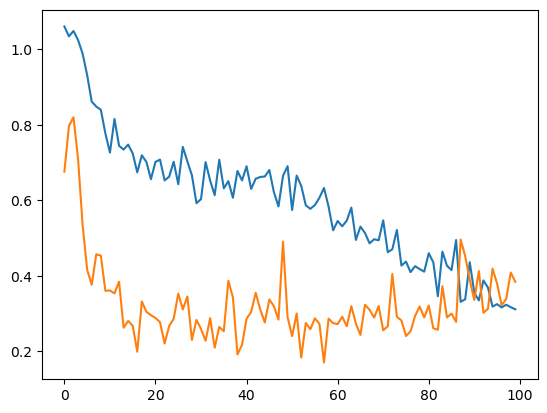

In [21]:
import support_functions, lstm_classes

resultsDF = pd.read_csv(r'{}\Results\1b-validation_results_with_optim_params.csv'.format(workDir)).drop(columns = 'Unnamed: 0')

# Get the optimal parameters
params = ['n_lstm_layers', 'n_hidden', 'n_dnn_layers', 'bidirectional', 'batch_size', 'initial_lr', 'clip_max_norm']
best_parameters = resultsDF.groupby(params, dropna=False).validation.mean().sort_values().head(1).reset_index().to_dict('records')[0]
best_seed = 1
# Fixed Parameters
X_COLUMNS = ['RSUI_A_w', 'RSUI_B_m', 'n_ecuador', 'acled_w', 'WTI_price']#, 'Diesel', 'Gasoline_midgrade']

nout= 2 # Periods to predict
sequence_len= 12
ninp= len(X_COLUMNS)

# Training
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
EPOCHS = 100
TOLERANCE = 50

results_dict, i = [], 0
   
# Instantiate the model
model = LSTMForecaster(ninp, n_outputs = nout, sequence_len = sequence_len, n_hidden = best_parameters['n_hidden'], n_deep_layers = best_parameters['n_dnn_layers'], use_cuda = USE_CUDA, 
                       bidirectional = best_parameters['bidirectional'], n_lstm_layers = best_parameters['n_lstm_layers']).to(device)

criterion = nn.MSELoss().to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr = best_parameters['initial_lr'])
scheduler = None

dataset = SequenceMaster(norm_df, tw = sequence_len, pw = nout, y_column = 'personas', x_columns = X_COLUMNS, validation_column = 'is_validation')

trainloader = DataLoader(dataset.train, batch_size = int(best_parameters['batch_size']), shuffle = True, drop_last = True)
testloader = DataLoader(dataset.validation, batch_size = int(best_parameters['batch_size']), shuffle = True, drop_last = True)
total_steps = len(trainloader) // EPOCHS    

x_past, y_past, x_future, y_target  = next(iter(testloader))
x_past.shape, y_past.shape, x_future.shape, y_target.shape

## #Training Loop
best_loss, steps_without_improvement = float('inf'), 0

# Set seed
torch.manual_seed(best_seed)
t_losses, v_losses = [], []
best_loss, steps_without_improvement = float('inf'), 0
for epoch in range(EPOCHS):
    train_loss, valid_loss = 0.0, 0.0

    # train step
    model.train()
    for x_past, y_past, x_future, y_target in trainloader:
        optimizer.zero_grad()
        x_past = x_past.to(device)
        y_target  = y_target.squeeze().to(device)
        # Forward Pass
        preds = model(x_past).squeeze()

        loss = criterion(preds, y_target)
        train_loss += loss.item()
        loss.backward()
        if best_parameters['clip_max_norm'] is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = best_parameters['clip_max_norm'])              
        optimizer.step()
        if scheduler is not None:    scheduler.step()   
        
    epoch_loss = train_loss / len(trainloader)
    t_losses.append(epoch_loss)

    # validation step
    model.eval()
    for x_past, y_past, x_future, y_target in testloader:
        with torch.no_grad():
            x_past, y_target = x_past.to(device), y_target.squeeze().to(device)
            preds = model(x_past).squeeze()
            error = criterion(preds, y_target)
        valid_loss += error.item()
    valid_loss = valid_loss / len(testloader)
    if valid_loss < best_loss:
        best_loss = valid_loss
        steps_without_improvement = 0
        best_model_name = save_checkpoint(model, optimizer, scheduler, workDir, best_loss, epoch, len(trainloader))
        
    else: # No improvement
        steps_without_improvement += 1
        if steps_without_improvement > TOLERANCE:    break
    
    v_losses.append(valid_loss)

    print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}')
plot_losses(t_losses, v_losses)

## Load Best Model for Prediction


In [27]:
best_model_name = r'{}\Results\model_checkpoint_57-23.pth'.format(workDir)

## Load Best Model
model = LSTMForecaster(ninp, n_outputs = nout, sequence_len = sequence_len, n_hidden = best_parameters['n_hidden'], n_deep_layers = best_parameters['n_dnn_layers'], use_cuda = USE_CUDA, 
                       bidirectional = best_parameters['bidirectional'], n_lstm_layers = best_parameters['n_lstm_layers']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = best_parameters['initial_lr'])
load_checkpoint(model, optimizer, best_model_name, device = device)

Model loaded from <== C:\Users\Ramon\OneDrive - Escuela Superior Politécnica del Litoral\Papers\Combustibles y Protestas\Resultados\Imputacion_LSTM\Resultados\model_checkpoint_57-23.pth
Model stats:
        - Epoch = 57
        - Validation Loss = 0.17090861712183272
    


C:\Users\Ramon\AppData\Local\Temp\ipykernel_13660\3564565594.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_name, map_location = dev

In [37]:
unshuffled_dataloader = DataLoader(dataset.train, batch_size=best_parameters['batch_size'], shuffle=False, drop_last=True)
P, Y = make_predictions_from_dataloader(model, unshuffled_dataloader)
P.shape, Y.shape

((736, 2), (736, 2))

<Axes: >

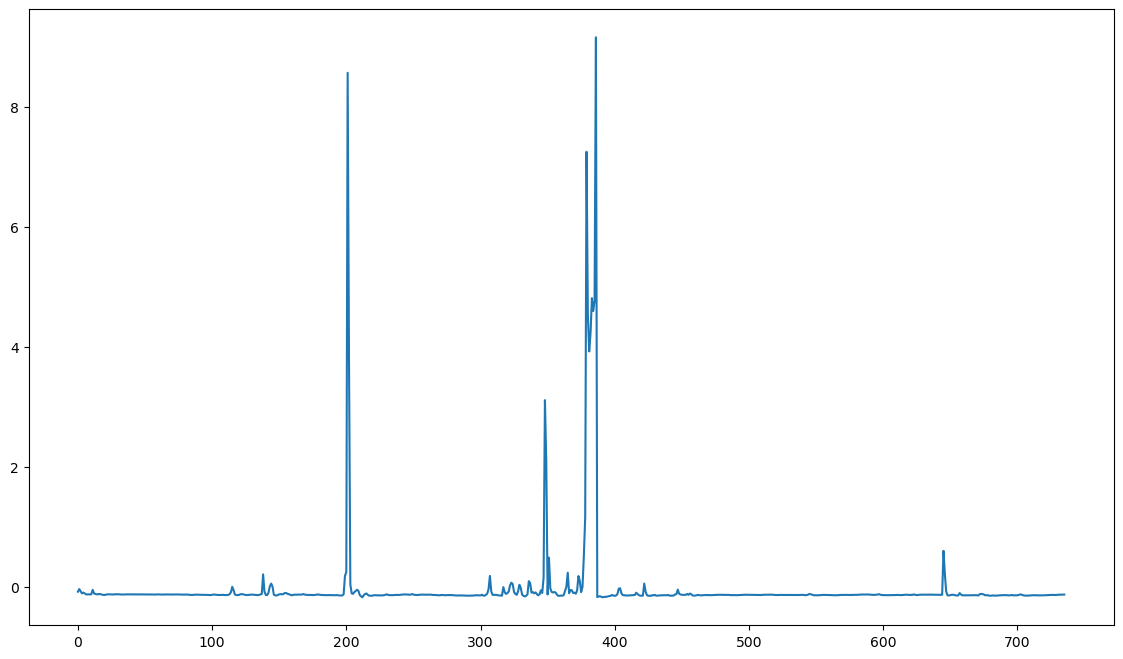

In [49]:
pdf = pd.DataFrame([P[:,0], Y[:,0]], index=['predictions', 'actuals']).T
pdf.predictions.plot(figsize = (14, 8))
